In [1]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [2]:
'./drive/My Drive/Colab Notebooks/MHK US Equity.xlxs'

'./drive/My Drive/Colab Notebooks/MHK US Equity.xlxs'

In [5]:
pip install tensorflow==1.13.2

     |████████████████████████████████| 92.6MB 56kB/s 
     |████████████████████████████████| 368kB 38.5MB/s 
     |████████████████████████████████| 3.2MB 44.3MB/s 
  Found existing installation: tensorflow-estimator 2.2.0
    Uninstalling tensorflow-estimator-2.2.0:
      Successfully uninstalled tensorflow-estimator-2.2.0
  Found existing installation: tensorboard 2.2.2
    Uninstalling tensorboard-2.2.2:
      Successfully uninstalled tensorboard-2.2.2
  Found existing installation: tensorflow 2.2.0
    Uninstalling tensorflow-2.2.0:
      Successfully uninstalled tensorflow-2.2.0


In [4]:
df = pd.read_excel(r'./drive/My Drive/Colab Notebooks/MHK US Equity.xlsx')
df_ori = pd.to_datetime(df.iloc[:, 0]).tolist()
df.head()

,DATA,PX_LAST,PX_ASK,PX_BID,NET_INCOME_MARGIN_ADJUSTED,WACC_COST_DEBT,BS_ST_BORROW,BS_LT_BORROW,IS_RD_EXPEND,PX_TO_BOOK_RATIO,IS_INT_EXPENSE,CF_FREE_CASH_FLOW,QUICK_RATIO,CUR_RATIO,WACC,WACC_COST_DEBT.1,WACC_COST_EQUITY,ROC_WACC_RATIO,BEST_NET_DEBT,NET_DEBT_TO_SHRHLDR_EQTY,NET_DEBT_%_CAPITAL,EBITDA,EBIT,BEST_NET_INCOME,EBITDA_TO_REVENUE,EBIT_TO_NET_SALES,BS_TOT_ASSET,SALES_REV_TURN,BEST_EST_PE_CUR_YR,BEST_PE_RATIO,CURR_ENTP_VAL,REVENUE_GROWTH_ADJUSTED_5Y_CAGR,SALES_GROWTH,EBITDA_GROWTH,GEO_GROW_EBITDA,NET_INC_GROWTH,GEO_GROW_NET_INC,BEST_EPS_NXT_YR,MOV_AVG_50D,MOV_AVG_200D,RSI_14D,RSI_30D,RSI_9D,PX_VOLUME
0,2013-12-31,148.90,148.91,148.90,7.0948,3.3894,127.218,2132.79,0,2.4261,22.148,87.163,0.7979,2.3362,10.9074,3.3894,12.4772,0.58,0,49.3466,33.0416,237.317,150.988,0.0,12.3339,7.8472,8494.177,1924.104,0.0,0.0,13029.0296,0.0,34.0224,48.5664,0.0,42.5703,0.0,0.0,138.8840,123.2779,65.1380,65.1935,67.9928,533632
1,2014-01-01,148.90,148.91,148.90,7.0948,3.3894,127.218,2132.79,0,2.4261,22.148,87.163,0.7979,2.3362,10.9074,3.3894,12.4772,0.58,0,49.3466,33.0416,237.317,150.988,0.0,12.3339,7.8472,8494.177,1924.104,0.0,0.0,13029.0296,0.0,34.0224,48.5664,0.0,42.5703,0.0,0.0,138.8840,123.2779,65.1380,65.1935,67.9928,533632
2,2014-01-02,149.11,149.10,149.07,7.0948,3.3894,127.218,2132.79,0,2.4295,22.148,87.163,0.7979,2.3362,10.9074,3.3894,12.4772,0.58,0,49.3466,33.0416,237.317,150.988,0.0,12.3339,7.8472,8494.177,1924.104,0.0,0.0,13044.2809,0.0,34.0224,48.5664,0.0,42.5703,0.0,0.0,139.3660,123.4603,65.4500,65.3393,68.4927,676997
3,2014-01-03,149.45,149.48,149.47,7.0948,3.3894,127.218,2132.79,0,2.4351,22.148,87.163,0.7979,2.3362,10.9074,3.3894,12.4772,0.58,0,49.3466,33.0416,237.317,150.988,0.0,12.3339,7.8472,8494.177,1924.104,0.0,0.0,13068.9733,0.0,34.0224,48.5664,0.0,42.5703,0.0,0.0,139.8022,123.6346,65.9809,65.5808,69.3643,521291
4,2014-01-06,147.34,147.40,147.36,7.0948,3.3894,127.218,2132.79,0,2.4007,22.148,87.163,0.7979,2.3362,10.9074,3.3894,12.4772,0.58,0,49.3466,33.0416,237.317,150.988,0.0,12.3339,7.8472,8494.177,1924.104,0.0,0.0,12915.7349,0.0,34.0224,48.5664,0.0,42.5703,0.0,0.0,140.1838,123.8148,59.8358,62.7730,58.1367,470527


In [3]:
from __future__ import print_function, division
from tensorflow.contrib import rnn
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm
sns.set()

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

In [5]:
minmax = MinMaxScaler().fit(df.iloc[:, 3:4].astype('float32')) # Close index
df_log = minmax.transform(df.iloc[:, 3:4].astype('float32')) # Close index
df_log = pd.DataFrame(df_log)
df_log.head()

,0
0,0.216807
1,0.216807
2,0.217788
3,0.220095
4,0.207925


In [6]:
test_size = 30
simulation_size = 10

df_train = df_log.iloc[:-test_size]
df_test = df_log.iloc[-test_size:]
df.shape, df_train.shape, df_test.shape

((1434, 44), (1404, 1), (30, 1))

In [0]:
def layer_norm(inputs, epsilon=1e-8):
    mean, variance = tf.nn.moments(inputs, [-1], keep_dims=True)
    normalized = (inputs - mean) / (tf.sqrt(variance + epsilon))

    params_shape = inputs.get_shape()[-1:]
    gamma = tf.get_variable('gamma', params_shape, tf.float32, tf.ones_initializer())
    beta = tf.get_variable('beta', params_shape, tf.float32, tf.zeros_initializer())
    
    outputs = gamma * normalized + beta
    return outputs

def multihead_attn(queries, keys, q_masks, k_masks, future_binding, num_units, num_heads):
    
    T_q = tf.shape(queries)[1]                                      
    T_k = tf.shape(keys)[1]                  

    Q = tf.layers.dense(queries, num_units, name='Q')                              
    K_V = tf.layers.dense(keys, 2*num_units, name='K_V')    
    K, V = tf.split(K_V, 2, -1)        

    Q_ = tf.concat(tf.split(Q, num_heads, axis=2), axis=0)                         
    K_ = tf.concat(tf.split(K, num_heads, axis=2), axis=0)                    
    V_ = tf.concat(tf.split(V, num_heads, axis=2), axis=0)                      

    align = tf.matmul(Q_, tf.transpose(K_, [0,2,1]))                      
    align = align / np.sqrt(K_.get_shape().as_list()[-1])                 

    paddings = tf.fill(tf.shape(align), float('-inf'))                   

    key_masks = k_masks                                                 
    key_masks = tf.tile(key_masks, [num_heads, 1])                       
    key_masks = tf.tile(tf.expand_dims(key_masks, 1), [1, T_q, 1])            
    align = tf.where(tf.equal(key_masks, 0), paddings, align)       

    if future_binding:
        lower_tri = tf.ones([T_q, T_k])                                          
        lower_tri = tf.linalg.LinearOperatorLowerTriangular(lower_tri).to_dense()  
        masks = tf.tile(tf.expand_dims(lower_tri,0), [tf.shape(align)[0], 1, 1]) 
        align = tf.where(tf.equal(masks, 0), paddings, align)                      
    
    align = tf.nn.softmax(align)                                            
    query_masks = tf.to_float(q_masks)                                             
    query_masks = tf.tile(query_masks, [num_heads, 1])                             
    query_masks = tf.tile(tf.expand_dims(query_masks, -1), [1, 1, T_k])            
    align *= query_masks
    
    outputs = tf.matmul(align, V_)                                                 
    outputs = tf.concat(tf.split(outputs, num_heads, axis=0), axis=2)             
    outputs += queries                                                             
    outputs = layer_norm(outputs)                                                 
    return outputs


def pointwise_feedforward(inputs, hidden_units, activation=None):
    outputs = tf.layers.dense(inputs, 4*hidden_units, activation=activation)
    outputs = tf.layers.dense(outputs, hidden_units, activation=None)
    outputs += inputs
    outputs = layer_norm(outputs)
    return outputs


def learned_position_encoding(inputs, mask, embed_dim):
    T = tf.shape(inputs)[1]
    outputs = tf.range(tf.shape(inputs)[1])                # (T_q)
    outputs = tf.expand_dims(outputs, 0)                   # (1, T_q)
    outputs = tf.tile(outputs, [tf.shape(inputs)[0], 1])   # (N, T_q)
    outputs = embed_seq(outputs, T, embed_dim, zero_pad=False, scale=False)
    return tf.expand_dims(tf.to_float(mask), -1) * outputs


def sinusoidal_position_encoding(inputs, mask, repr_dim):
    T = tf.shape(inputs)[1]
    pos = tf.reshape(tf.range(0.0, tf.to_float(T), dtype=tf.float32), [-1, 1])
    i = np.arange(0, repr_dim, 2, np.float32)
    denom = np.reshape(np.power(10000.0, i / repr_dim), [1, -1])
    enc = tf.expand_dims(tf.concat([tf.sin(pos / denom), tf.cos(pos / denom)], 1), 0)
    return tf.tile(enc, [tf.shape(inputs)[0], 1, 1]) * tf.expand_dims(tf.to_float(mask), -1)

def label_smoothing(inputs, epsilon=0.1):
    C = inputs.get_shape().as_list()[-1]
    return ((1 - epsilon) * inputs) + (epsilon / C)

class Attention:
    def __init__(self, size_layer, embedded_size, learning_rate, size, output_size,
                 num_blocks = 2,
                 num_heads = 8,
                 min_freq = 50):
        self.X = tf.placeholder(tf.float32, (None, None, size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        
        encoder_embedded = tf.layers.dense(self.X, embedded_size)
        encoder_embedded = tf.nn.dropout(encoder_embedded, keep_prob = 0.8)
        x_mean = tf.reduce_mean(self.X, axis = 2)
        en_masks = tf.sign(x_mean)
        encoder_embedded += sinusoidal_position_encoding(self.X, en_masks, embedded_size)
        
        for i in range(num_blocks):
            with tf.variable_scope('encoder_self_attn_%d'%i,reuse=tf.AUTO_REUSE):
                encoder_embedded = multihead_attn(queries = encoder_embedded,
                                             keys = encoder_embedded,
                                             q_masks = en_masks,
                                             k_masks = en_masks,
                                             future_binding = False,
                                             num_units = size_layer,
                                             num_heads = num_heads)

            with tf.variable_scope('encoder_feedforward_%d'%i,reuse=tf.AUTO_REUSE):
                encoder_embedded = pointwise_feedforward(encoder_embedded,
                                                    embedded_size,
                                                    activation = tf.nn.relu)
                
        self.logits = tf.layers.dense(encoder_embedded[-1], output_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )
        
def calculate_accuracy(real, predict):
    real = np.array(real) + 1
    predict = np.array(predict) + 1
    percentage = 1 - np.sqrt(np.mean(np.square((real - predict) / real)))
    return percentage * 100

def anchor(signal, weight):
    buffer = []
    last = signal[0]
    for i in signal:
        smoothed_val = last * weight + (1 - weight) * i
        buffer.append(smoothed_val)
        last = smoothed_val
    return buffer

In [0]:
num_layers = 1
size_layer = 128
timestamp = 5
epoch = 300
dropout_rate = 0.8
future_day = test_size
learning_rate = 0.001

In [0]:
def forecast():
    tf.reset_default_graph()
    modelnn = Attention(size_layer, size_layer, learning_rate, df_log.shape[1], df_log.shape[1])
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())
    date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()

    pbar = tqdm(range(epoch), desc = 'train loop')
    for i in pbar:
        total_loss, total_acc = [], []
        for k in range(0, df_train.shape[0] - 1, timestamp):
            index = min(k + timestamp, df_train.shape[0] - 1)
            batch_x = np.expand_dims(
                df_train.iloc[k : index, :].values, axis = 0
            )
            batch_y = df_train.iloc[k + 1 : index + 1, :].values
            logits, _, loss = sess.run(
                [modelnn.logits, modelnn.optimizer, modelnn.cost],
                feed_dict = {
                    modelnn.X: batch_x,
                    modelnn.Y: batch_y
                },
            ) 
            total_loss.append(loss)
            total_acc.append(calculate_accuracy(batch_y[:, 0], logits[:, 0]))
        pbar.set_postfix(cost = np.mean(total_loss), acc = np.mean(total_acc))
    
    future_day = test_size

    output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
    output_predict[0] = df_train.iloc[0]
    upper_b = (df_train.shape[0] // timestamp) * timestamp

    for k in range(0, (df_train.shape[0] // timestamp) * timestamp, timestamp):
        out_logits = sess.run(
            modelnn.logits,
            feed_dict = {
                modelnn.X: np.expand_dims(
                    df_train.iloc[k : k + timestamp], axis = 0
                )
            },
        )
        output_predict[k + 1 : k + timestamp + 1] = out_logits

    if upper_b != df_train.shape[0]:
        out_logits = sess.run(
            modelnn.logits,
            feed_dict = {
                modelnn.X: np.expand_dims(df_train.iloc[upper_b:], axis = 0)
            },
        )
        output_predict[upper_b + 1 : df_train.shape[0] + 1] = out_logits
        future_day -= 1
        date_ori.append(date_ori[-1] + timedelta(days = 1))
    
    for i in range(future_day):
        o = output_predict[-future_day - timestamp + i:-future_day + i]
        out_logits = sess.run(
            modelnn.logits,
            feed_dict = {
                modelnn.X: np.expand_dims(o, axis = 0)
            },
        )
        output_predict[-future_day + i] = out_logits[-1]
        date_ori.append(date_ori[-1] + timedelta(days = 1))
    
    output_predict = minmax.inverse_transform(output_predict)
    deep_future = anchor(output_predict[:, 0], 0.3)
    
    return deep_future[-test_size:]

In [10]:
results = []
for i in range(simulation_size):
    print('simulation %d'%(i + 1))
    results.append(forecast())

simulation 1
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.


train loop: 100%|██████████| 300/300 [09:58<00:00,  2.00s/it, acc=89.1, cost=0.0275]


simulation 2


/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 300/300 [10:29<00:00,  2.10s/it, acc=88.8, cost=0.029]


simulation 3


/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 300/300 [10:12<00:00,  2.04s/it, acc=88.9, cost=0.0285]


simulation 4


/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 300/300 [10:32<00:00,  2.11s/it, acc=88.9, cost=0.0286]


simulation 5


/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 300/300 [10:21<00:00,  2.07s/it, acc=88.7, cost=0.0299]


simulation 6


/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 300/300 [09:58<00:00,  1.99s/it, acc=88.9, cost=0.0288]


simulation 7


/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 300/300 [10:15<00:00,  2.05s/it, acc=87.1, cost=0.0391]


simulation 8


/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 300/300 [10:05<00:00,  2.02s/it, acc=85.4, cost=0.0539]


simulation 9


/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 300/300 [10:18<00:00,  2.06s/it, acc=88.9, cost=0.0286]


simulation 10


/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 300/300 [10:14<00:00,  2.05s/it, acc=89.1, cost=0.0277]


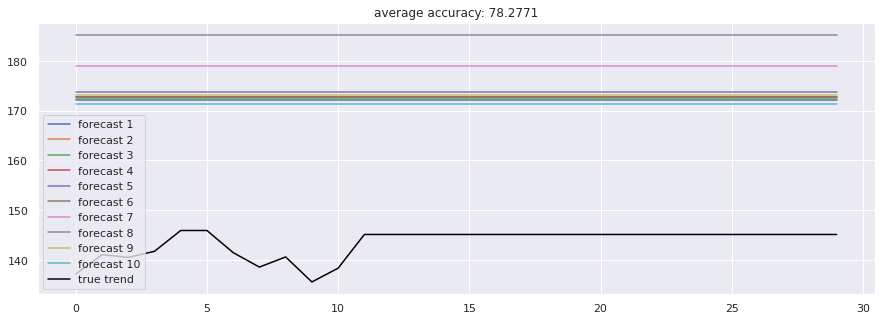

In [11]:
accuracies = [calculate_accuracy(df['PX_LAST'].iloc[-test_size:].values, r) for r in results]

plt.figure(figsize = (15, 5))
for no, r in enumerate(results):
    plt.plot(r, label = 'forecast %d'%(no + 1))
plt.plot(df['PX_LAST'].iloc[-test_size:].values, label = 'true trend', c = 'black')
plt.legend()
plt.title('average accuracy: %.4f'%(np.mean(accuracies)))
plt.show()